# Unconditional Language Models (4.1bis & 4.2)


*   STEP 1 TOKENIZE THE DATA
*   STEP 2 PREPROCESS INTO SMALLER SEQUENCES FOR TRAINING
*   STEP 3 TRAIN BIDIRECTIONAL GRU RNN TO PRODUCE TEXT
*   STEP 4 TRAIN CONCATENATED GRU RNN WITH ATTENTION
*   STEP 5 EVALUATE RESULTS (BLEU & UNIVERSAL COSINE SIMILARITY)



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## STEP 0 // IMPORT OUR STUFF

In [ ]:
# !pip install numpy
import pandas as pd
import numpy as np
import ast
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import compress

import random
import sys
import io

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Masking, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dot, Permute
from tensorflow.keras.layers import Conv1D, Activation, Multiply, Flatten, BatchNormalization, Add
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax
from tensorflow.keras import activations

from sklearn.model_selection import train_test_split
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [ ]:
data = pd.read_csv('/content/drive/My Drive/CS230/finaldata.csv')
train = pd.read_csv('/content/drive/My Drive/CS230/finaldata_train.csv')
test = pd.read_csv('/content/drive/My Drive/CS230/finaldata_test.csv')

In [ ]:
pd.set_option('display.max_colwidth', -1)
data.head(5).iloc[:, :3]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,genres,overview,title
0,"['animation', 'comedy', 'family']","Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",Toy Story
1,"['adventure', 'fantasy', 'family']","When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",Jumanji
2,"['romance', 'comedy']","A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max.",Grumpier Old Men
3,['comedy'],"Just when George Banks has recovered from his daughter's wedding, he receives the news that she's pregnant ... and that George's wife, Nina, is expecting too. He was planning on selling their home, but that's a plan that -- like George -- will have to change with the arrival of both a grandchild and a kid of his own.",Father of the Bride Part II
4,"['action', 'crime', 'drama', 'thriller']","Obsessive master thief, Neil McCauley leads a top-notch crew on various insane heists throughout Los Angeles while a mentally unstable detective, Vincent Hanna pursues him without rest. Each man recognizes and respects the ability and the dedication of the other even though they are aware their cat-and-mouse game may end in violence.",Heat


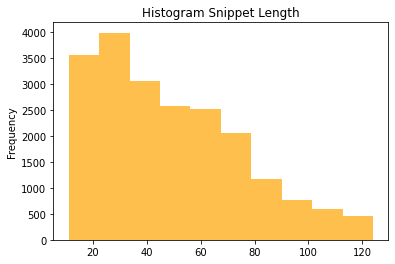

Average Snippet is:  48  words.


In [ ]:
# Reminder of the length of the snippets...
data['length'].plot(kind='hist', alpha=0.7, color='orange')
plt.title('Histogram Snippet Length')

plt.show()

print('Average Snippet is: ', int(np.mean(data.length)), ' words.')

## STEP1 // LET'S TOKENIZE THE DATA

In [ ]:
data['overview_stop']=['<START> '+a+' <END>' for a in data.overview_stop]
train['overview_stop']=['<START> '+a+' <END>' for a in train.overview_stop]
test['overview_stop']=['<START> '+a+' <END>' for a in test.overview_stop]

In [ ]:
# Tokenizing / Create a Tokenizer object

liststrings = list(data.overview_stop)
size_dict = 10000
tokenizer = Tokenizer(num_words= size_dict+1, 
                      filters='!"#$%&()*+,-/:;=?@[\\]^_`{|}~\t\n', 
                      split=' ', 
                      oov_token='<UNK>',
                      document_count=0)


tokenizer.fit_on_texts(liststrings) 
seqtokens = tokenizer.texts_to_sequences(liststrings)
traintokens = tokenizer.texts_to_sequences(list(train.overview_stop))
testtokens = tokenizer.texts_to_sequences(list(test.overview_stop))

tokenizer_config = tokenizer.get_config()
dict_counts = tokenizer_config['word_counts']
dict_index = tokenizer_config['word_index'] 

In [ ]:
tokenizer.sequences_to_texts(seqtokens)[:5] 

In [ ]:
sequnk = [[1 if x ==1 else 0 for x in s] for s in seqtokens]
count_unk = [np.sum(x) for x in sequnk]
freq_unk = [float(np.sum(x)/len(x)) for x in sequnk]

In [ ]:
# Reminder of the length of the snippets...
print('Average Number of <UNK>s is: ', np.round(np.mean(count_unk),1))
print('Max Number of <UNK>s is: ', np.round(np.max(count_unk),1))

print('Average Freq of <UNK>s is: ', np.round(np.mean(freq_unk),3))
print('Max Freq of <UNK>s is: ', np.round(np.max(freq_unk),3))

Average Number of <UNK>s is:  2.4
Max Number of <UNK>s is:  12
Average Freq of <UNK>s is:  0.041
Max Freq of <UNK>s is:  0.121


In [ ]:
lengths = [len(x) for x in seqtokens]
maxlen = max(lengths)
m = len(seqtokens)

In [ ]:
x = pad_sequences(seqtokens, maxlen=maxlen)

In [ ]:
y = np.array(data[['drama','comedy','thriller','romance','adventure','family']])

In [ ]:
print("x shape: ", x.shape)
print("y shape: ", y.shape)

x shape:  (20691, 136)
y shape:  (20691, 6)


In [ ]:
dict_index

##STEP2 // PRE-PROCESS INTO SMALLER SEQUENCES

In [ ]:
### WORD-LEVEL LANGUAGE MODEL WITH A FIXED WINDOW ###
# Script inspired in parts by the CHAR-LEVEL model: lstm_text_generation.py by fchollet https://github.com/keras-team/keras
# Adapted by: ceciloge@stanford.edu

# Preprocess the text into smaller sequences of words on one side (window length), and output next word on the other
win_len = 10
#tokens = list(compress(seqtokens, drama_filter))
tokens = traintokens
x_rnn = []
y_rnn = []

for j, text in enumerate(tokens):
  if j%5000 == 0: print("We're at...", j)
  for i in range(len(text)-win_len):
    x_rnn.append(text[i:i+win_len])
    y_rnn.append(text[i+win_len])

print("Total number of smaller sequences: ", len(x_rnn))

We're at... 0
We're at... 5000
We're at... 10000
We're at... 15000
We're at... 20000
Total number of smaller sequences:  878744


In [ ]:
# Turning our sequences into arrays
x_rnn_array = np.array([np.array(s) for s in x_rnn])
y_rnn_array = np.array([np.array(s) for s in y_rnn])-1
print('x Shape: ',x_rnn_array.shape)
print('y Shape: ',y_rnn_array.shape)

x Shape:  (878744, 10)
y Shape:  (878744,)


##STEP3 // TRAIN BIDIRECTIONAL GRU RNN TO PRODUCE TEXT

In [ ]:
### RNN LANGUAGE MODEL / NOW BIDIRECTIONAL ###
# By: ceciloge@stanford.edu

# Input & Embedding
seq_input = Input(shape=(win_len,), name = 'miniseq')
h = Embedding(size_dict+1, 64, input_length = win_len, mask_zero=True, name = 'embedding')(seq_input)

# Two BIDIRECTIONAL GRU Layers
h = Bidirectional (GRU(256, name = 'GRU1', return_sequences= True, kernel_initializer = 'glorot_normal'))(h)
h = Bidirectional (GRU(256, name = 'GRU2', kernel_initializer = 'glorot_normal'))(h)

# Final Dense Layers
h = Dense(512, activation = 'relu', name = 'dense1')(h)
h = Dense(2560, activation = 'relu', name = 'dense2')(h)
next_word = Dense(size_dict, activation='linear', name = 'final')(h)

gen_model = Model(inputs = seq_input, outputs = next_word)
gen_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
miniseq (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 64)            640064    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 512)           494592    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1182720   
_________________________________________________________________
dense1 (Dense)               (None, 512)               262656    
_________________________________________________________________
dense2 (Dense)               (None, 2560)              1313280   
_________________________________________________________________
final (Dense)                (None, 10000)            

In [ ]:
# Functions to produce text with our RNN model

every = 5
end = tokenizer.texts_to_sequences([['<end>']])[0][0] 
start = tokenizer.texts_to_sequences([['<start>']])[0][0] 
dicke = tokenizer.texts_to_sequences([["dickens'"]])[0][0]

def sample(preds, greedy = False):
  # This first function samples the next word based on the output logits from the model
  preds = np.asarray(preds).astype('float64')
  #print(preds)
  preds[0] = np.min(preds) # Minimize prob of <UNK> from being generated as it is not useful
  preds[start-1] = np.min(preds) # Minimize prob of <start> from being generated as it is not useful
  preds[dicke-1] = np.min(preds) # Minimize prob of "dicken'" from being generated as it is not useful
  preds = preds-np.max(preds)
  preds = np.exp(preds)
  preds = preds/np.sum(preds)
  samp = np.random.multinomial(1, preds, 1)
  if greedy: 
    out = max(1, np.argmax(preds))
  else: 
    out = np.argmax(samp)
  return out+1

def generate_text(epoch, _):
  # This second function prints generated text at end of every few epochs
  if epoch%every == 0:
    print()
    input = '<start> when siblings judy and peter discover a board game'
    print('Seed: "' + input + '"')
    output = []
    x_in = np.array(tokenizer.texts_to_sequences([input])[0])
    i = -1
    count = 0
    while i != end and count < 35:     
      preds = gen_model.predict(x_in.reshape((1,x_in.shape[0])), verbose=0)[0]
      i = sample(preds)
      x_in = np.append(x_in[1:],i)
      output.append(i)
      count+=1
      
    print(input+" "+tokenizer.sequences_to_texts([output])[0])

# Defining our callbacks:
checkpoint = ModelCheckpoint(filepath='model',
                             frequency = "epoch",
                             save_weights_only = True,
                             verbose = 0)

gen_callback = LambdaCallback(on_epoch_end=generate_text)


In [ ]:
# Optimizer, Loss & Compiling
opt = Adamax(learning_rate=0.001)
loss = SparseCategoricalCrossentropy(from_logits=True, name='sparse_cce')
gen_model.compile(loss=loss, optimizer=opt)
print('Ready!')

Ready!


In [ ]:
gen_model.load_weights('/content/drive/My Drive/CS230/Models/bidirectional')

In [ ]:
# Let's train!
gen_model.fit(x_rnn_array, y_rnn_array,
          batch_size=256,
          epochs= 5,
          callbacks=[gen_callback, checkpoint],
          verbose = 1)

Epoch 1/5
3432/3433 [============================>.] - ETA: 0s - loss: 0.7622
Seed: "<start> when siblings judy and peter discover a board game"
<start> when siblings judy and peter discover a board game of evidence that suggests that they must resist . goofy lucas and the the living parade give way to monsters their lives to become a covert courier . when they get their father's own life
3433/3433 [==============================] - 147s 43ms/step - loss: 0.7622
Epoch 2/5
3433/3433 [==============================] - 143s 42ms/step - loss: 0.7550
Epoch 3/5
3433/3433 [==============================] - 145s 42ms/step - loss: 0.7538
Epoch 4/5
3433/3433 [==============================] - 147s 43ms/step - loss: 0.7479
Epoch 5/5
3433/3433 [==============================] - 145s 42ms/step - loss: 0.7445


In [ ]:
gen_model.save_weights('/content/drive/My Drive/CS230/Models/bidirectional')

In [ ]:
gen_model.evaluate(x_rnn_array, y_rnn_array)

27461/27461 [==============================] - 169s 6ms/step - loss: 0.7174


0.7174374461174011

In [ ]:
# Let's choose several seeds:

string_seed0 = 'judy and peter discover a board game that will'
string_seed1 = 'CS230 students met a year ago for the'
string_seed2 = 'professor andrew is on a mission to' 
string_seed3 = 'professor andrew goes on an adventure to'
string_seed4 = 'CS230 students discover a'
string_seed5 = 'a group of friends decides to go out for'

def model_generate_text(model = gen_model, seed = string_seed1, length = 100, greedy = False, verbose = True, endtok=True):
    # This function generates text from a given seed - works like the callback function.
    input = '<START> '+seed
    output = []
    
    x_in = pad_sequences(tokenizer.texts_to_sequences([input]), maxlen=10)

    i = -1
    count = 0
    if endtok == True:
      while i != end and count <length:     
        preds = model.predict(x_in, verbose=0)[0]
        i = sample(preds, greedy=greedy)
        x_in = np.append(x_in[:,1:],i).reshape((1,10))
        output.append(i)
        count +=1
    else:
      while count <length:     
        preds = model.predict(x_in, verbose=0)[0]
        i = sample(preds, greedy=greedy)
        x_in = np.append(x_in[:,1:],i).reshape((1,10))
        output.append(i)
        count +=1
    if verbose: print(seed+" "+tokenizer.sequences_to_texts([output])[0])
    return str(seed+" "+tokenizer.sequences_to_texts([output])[0]), output

In [ ]:
# Now let's produce text with our fully trained model: 

#text0, output0 = model_generate_text(model = gen_model, seed = string_seed0, length = 65, greedy = True)
#text0, output0 = model_generate_text(model = gen_model, seed = string_seed0, length = 65, greedy = False)
print(20*"_"+" RANDOM " + 20*"_")
print(" ")
text1, output1 = model_generate_text(model = gen_model, seed = string_seed1, length = 50)
text2, output2 = model_generate_text(model = gen_model, seed = string_seed2, length = 50)
text3, output3 = model_generate_text(model = gen_model, seed = string_seed3, length = 50)
text4, output4 = model_generate_text(model = gen_model, seed = string_seed4, length = 50)
text5, output5 = model_generate_text(model = gen_model, seed = string_seed5, length = 50)
print(" ")
print(50*"_")
print(" ")
text1, output1 = model_generate_text(model = gen_model, seed = string_seed1, length = 50)
text2, output2 = model_generate_text(model = gen_model, seed = string_seed2, length = 50)
text3, output3 = model_generate_text(model = gen_model, seed = string_seed3, length = 50)
text4, output4 = model_generate_text(model = gen_model, seed = string_seed4, length = 50)
text5, output5 = model_generate_text(model = gen_model, seed = string_seed5, length = 50)
print(" ")
print(20*"_"+" GREEDY " + 20*"_")
print(" ")
text6, output6 = model_generate_text(model = gen_model, seed = string_seed1, length = 50, greedy = True)
text7, output7 = model_generate_text(model = gen_model, seed = string_seed2, length = 50, greedy = True)
text8, output8 = model_generate_text(model = gen_model, seed = string_seed3, length = 50, greedy = True)
text9, output9 = model_generate_text(model = gen_model, seed = string_seed4, length = 50, greedy = True)
text10, output10 = model_generate_text(model = gen_model, seed = string_seed5, length = 50, greedy = True)
print(" ")


____________________ RANDOM ____________________
 
CS230 students met a year ago for the first time . <end>
professor andrew is on a mission to find love and murder with every room beautiful ashley brown . as tom tries to balance the night with her fiancé she has been violently after all . ultimately it is all the first time to pass orders to sell them into the zoo to infiltrate the crew hot on
professor andrew goes on an adventure to the top of the ordinary . <end>
CS230 students discover a dark conspiracy behind an explosion with a mysterious past despite a mad array of programming . <end>
a group of friends decides to go out for a role that will prove her business succeeds in the passage of his family his zoo florence is confronted with jack taylor who gets thrust into the world even if the clouds government overdose all have been fired . trying on ice makes a surprising face with a beautiful celebrity
 
__________________________________________________
 
CS230 students met a year 

##STEP 4 // TRAIN CONCATENATED GRU RNN WITH ATTENTION

In [ ]:
### RNN LANGUAGE MODEL / WITH ATTENTION ###
# By: ceciloge@stanford.edu

# Input & Embedding
seq_input = Input(shape=(win_len,), name = 'miniseq')
h1 = Embedding(size_dict+1, 64, input_length = win_len, mask_zero=True, name = 'embedding')(seq_input)

# Two GRU Layers
h2 = GRU(256, name = 'GRU1', return_sequences= True, kernel_initializer = 'glorot_normal')(h1)
h3 = GRU(256, name = 'GRU2', return_sequences= True, kernel_initializer = 'glorot_normal')(h2)

# Concatenate both GRU Layer Outputs
h4 = Concatenate()([h1,h2,h3])

# Attention done in several steps
a = Dense(1, use_bias=False, activation='linear')(h4)
a = Permute((2, 1))(a)
a = Flatten()(a)
a = Activation('softmax')(a)
h = Dot(axes = [1,1])([a,h3])


# Final Dense Layers
h = Dense(512, activation = 'relu', name = 'dense1', kernel_initializer = 'he_normal')(h)
h = Dense(2560, activation = 'relu', name = 'dense2', kernel_initializer = 'he_normal')(h)
next_word = Dense(size_dict, activation='linear', name = 'final')(h)


gen_model2 = Model(inputs = seq_input, outputs = next_word)
gen_model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
miniseq (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 64)       640064      miniseq[0][0]                    
__________________________________________________________________________________________________
GRU1 (GRU)                      (None, 10, 256)      247296      embedding[0][0]                  
__________________________________________________________________________________________________
GRU2 (GRU)                      (None, 10, 256)      394752      GRU1[0][0]                       
_______________________________________________________________________________________

In [ ]:
# Functions to produce text with our Attention RNN

every = 5

def generate_text2(epoch, _):
  # This second function prints generated text at end of every few epochs
  if epoch%every == 0:
    print()
    input = 'when siblings judy and peter discover a board game that'
    print('Seed: "' + input + '"')
    output = []
    x_in = np.array(tokenizer.texts_to_sequences([input])[0])
    i = -1
    count = 0
    while i != end and count < 35:     
      preds = gen_model2.predict(x_in.reshape((1,x_in.shape[0])), verbose=0)[0]
      i = sample(preds)
      x_in = np.append(x_in[1:],i)
      output.append(i)
      count+=1
    print(input+" "+tokenizer.sequences_to_texts([output])[0])


# Defining our callbacks - reusing code from previous model:
checkpoint2 = ModelCheckpoint(filepath='model2',
                             frequency = "epoch",
                             save_weights_only = True,
                             verbose = 0)

gen_callback2 = LambdaCallback(on_epoch_end=generate_text2)

In [ ]:
opt = Adamax(learning_rate=0.00000001)
loss = SparseCategoricalCrossentropy(from_logits=True, name='sparse_cce')
gen_model2.compile(loss=loss, optimizer=opt)
print('Ready!')

Ready!


In [ ]:
gen_model2.load_weights('/content/drive/My Drive/CS230/Models/attention')

In [ ]:
#Let's train!
gen_model2.fit(x_rnn_array, y_rnn_array,
          batch_size=256,
          epochs=15,
          callbacks=[gen_callback2, checkpoint2])

In [ ]:
gen_model2.save_weights('/content/drive/My Drive/CS230/Models/attention')

In [ ]:
gen_model2.evaluate(x_rnn_array, y_rnn_array)

27461/27461 [==============================] - 134s 5ms/step - loss: 0.9059


0.9059416055679321

In [ ]:
# Now let's produce text with our fully trained model:2  

print(20*"_"+" RANDOM " + 20*"_")
print(" ")
text1, output1 = model_generate_text(model = gen_model2, seed = string_seed1, length = 50)
text2, output2 = model_generate_text(model = gen_model2, seed = string_seed2, length = 50)
text3, output3 = model_generate_text(model = gen_model2, seed = string_seed3, length = 50)
text4, output4 = model_generate_text(model = gen_model2, seed = string_seed4, length = 50)
text5, output5 = model_generate_text(model = gen_model2, seed = string_seed5, length = 50)
print(" ")
print(50*"_")
print(" ")
text1, output1 = model_generate_text(model = gen_model2, seed = string_seed1, length = 50)
text2, output2 = model_generate_text(model = gen_model2, seed = string_seed2, length = 50)
text3, output3 = model_generate_text(model = gen_model2, seed = string_seed3, length = 50)
text4, output4 = model_generate_text(model = gen_model2, seed = string_seed4, length = 50)
text5, output5 = model_generate_text(model = gen_model2, seed = string_seed5, length = 50)
print(" ")
print(50*"_")
print(" ")
print(20*"_"+" GREEDY " + 20*"_")
print(" ")
text6, output6 = model_generate_text(model = gen_model2, seed = string_seed1, length = 50, greedy = True)
text7, output7 = model_generate_text(model = gen_model2, seed = string_seed2, length = 50, greedy = True)
text8, output8 = model_generate_text(model = gen_model2, seed = string_seed3, length = 50, greedy = True)
text9, output9 = model_generate_text(model = gen_model2, seed = string_seed4, length = 50, greedy = True)
text10, output10 = model_generate_text(model = gen_model2, seed = string_seed5, length = 50, greedy = True)
print(" ")


____________________ RANDOM ____________________
 
CS230 students met a year ago for the perfect event . soon after they arrive we meet may come they have an her quest to discover the truth about the death of her mother . <end>
professor andrew is on a mission to individual strip dropping a great career with back out all life to the spine but only he can get himself close behind by the uncle's version of ireland she is befriended by the volatile sir jim parent emma our only key point for killer rather bizarre thief maya and old
professor andrew goes on an adventure to theme camp after a car accident . his former wife is linda the only person to trust her plan to be ex boys . social problems start nowhere he needs to kill seeing him that he and his next time protégé bruce make life in her one set for its
CS230 students discover a sooner rapidly damaged ninja drive for a . enter closest and attempts to fix ecstasy engaging in a self destructive story involving money and frank and his cra

## STEP 4 // EVALUATE RESULTS

In [ ]:
import tensorflow_hub as hub
univ_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
# EVALUATE BLEU & COSINE SIMILARITY ON THE TEST SET

def cosine_sim(x,y):
    num = np.sum(x*y)
    den = np.sqrt(np.sum(x**2))*np.sqrt(np.sum(y**2))
    return num/float(den)

def evaluate_gen(version, greedy = True):
  bleu = []
  sim = []
  fun = model_generate_text
  if version == 1: 
    model = gen_model
  else:
    model = gen_model2   
  
  for j, synopsis in enumerate(testtokens):
    #From test set:
    input = tokenizer.sequences_to_texts([synopsis[:10]])[0]
    output_test = synopsis[10:]
    output_test_string = tokenizer.sequences_to_texts([output_test])[0]
    output_test_list = [tokenizer.sequences_to_texts([[i]])[0] for i in output_test]
    emb_test = univ_embed([output_test_string])
    l = len(synopsis)-10


    #From model:
    _, output = fun(model = model, seed = input, length = l, greedy = greedy, verbose = False, endtok = False)
    output_string = tokenizer.sequences_to_texts([output])[0]
    output_list = [tokenizer.sequences_to_texts([[i]])[0] for i in output]
    emb = univ_embed([output_string])
    #Similarity Scores:
    b = sentence_bleu([output_test_list], output_list, smoothing_function=SmoothingFunction().method2)
    s = cosine_sim(emb, emb_test)

    if j%100 == 0: 
      print(j, " done!")
      #print("bleu: ", b)
      #print("sim: ", s)

    bleu.append(b)
    sim.append(s)
  
  bleu_score = np.mean(bleu)
  sim_score = np.mean(sim)
  #print("BLEU: ", bleu_score)
  #print("COS. SIMILARITY: ", sim_score)
  return bleu_score, sim_score

In [ ]:
print("RNN Bid. Performance:")
bleu_score_RNN, sim_score_RNN = evaluate_gen(1)

print("----------- RNN Bid. Performance -----------")
print("BLEU: ", np.round(bleu_score_RNN,4))
print("COS. SIMILARITY: ", np.round(sim_score_RNN,4))
print(" ")


RNN Bid. Performance:
----------- RNN Bid. Performance -----------
BLEU:  0.0663
COS. SIMILARITY:  0.2482
 


In [ ]:
print("Attention Performance:")
bleu_score_att, sim_score_att = evaluate_gen(2)

print("-------- Attention Performance --------")
print("BLEU: ", np.round(bleu_score_att,4))
print("COS. SIMILARITY: ", np.round(sim_score_att,4))

Attention Performance:
-------- Attention Performance --------
BLEU:  0.0646
COS. SIMILARITY:  0.2425
